In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time
import numpy.linalg as linalg
import cv2
import random
from mpl_toolkits.mplot3d import Axes3D
from multiprocessing import Queue, Process
%matplotlib notebook
orb = cv2.ORB_create()
N = 250
s = 8
random.seed(0xDEADBEEF)

In [2]:
#function for computing the fundamental matrix
def computeF(xl, xr):
    A = []
    for i in range(len(xl)):
        x = xl[i]
        x_prime = xr[i]
        #Put a row into the matrix, with formula fropm class.
        A.append([x[0]*x_prime[0], x[1]*x_prime[0], x_prime[0],
                  x[0]*x_prime[1], x[1]*x_prime[1], x_prime[1], x[0], x[1], 1])
    #Get actual fundamental matrix.
    A = np.array(A)
    _, _, V = linalg.svd(A)
    F = V[-1,:].reshape((3,3))
    U, s, V = linalg.svd(F)
    sigma = np.diag(s)
    sigma[2,2] = 0
    return np.matmul(U, np.matmul(sigma, V))
    
def ransacF(points, kp1, kp2):
    n = 0 
    currF = None
    maxInliers = 0
    # run ransac
    for n in range(N):
        sample = random.sample(points, s)
        leftPoints = [kp1[point.trainIdx].pt for point in sample]
        rightPoints = [kp2[point.queryIdx].pt for point in sample]
        # compute our F matrix
        FToTest = computeF(leftPoints, rightPoints)
        numIn = 0
        for match in points:
            p = kp1[match.trainIdx].pt
            q = kp2[match.queryIdx].pt
            if (abs(np.matmul([p[0], p[1], 1], np.matmul(FToTest, [q[0], q[1], 1])))) < .01:
                numIn += 1
        if currF is None:
            currF = FToTest
        if numIn > maxInliers:
            maxInliers = numIn
            currF = FToTest
    return currF

In [3]:
npz = np.load("calibration/matrices.npz")
K = np.eye(3) #npz['cameraMatrix']
K_prime = np.transpose(K)
W = np.matrix([[0, -1, 0], [1, 0, 0], [0, 0, 1]])
negW = np.transpose(W)
Z = np.matrix([[0, 1, 0], [-1, 0, 0], [0, 0, 0]])
trans = np.transpose
svd = linalg.svd
matmul = np.matmul
location = np.reshape((np.array([0, 0, 0, 1])), (4, 1))
# Compute null space of matrix A, algorithm from scipy mailing lists
def null(A, eps=1e-15):
    u, s, vh = linalg.svd(A)
    null_mask = (s <= eps)
    null_space = np.compress(null_mask, vh, axis=0)
    return trans(null_space)

def updateLoc(F, points):
    global location
    # Need to find K for the camera
    E = matmul(K, matmul(F, K_prime))
    # https://en.wikipedia.org/wiki/Essential_matrix
    U, sigma, Vt = svd(E)
    t_mat = matmul(U, matmul(W, matmul(np.diag(sigma), trans(U))))
    RPos = matmul(U, matmul(W, Vt))
    opt = 0
    t = null(t_mat)
    motion = np.hstack([RPos, t])
    motion = np.vstack([motion, np.array([0, 0, 0, 1])])
    location = np.reshape((np.matmul(motion, location)), (4, 1))
    return None

In [4]:
def queueFrames():
    cap = cv2.VideoCapture(0)
    i = 0
    while cap.isOpened():
        i += 1
        ret, frame = cap.read()
        if ret == False:
            queueFrames.q.put(None)
            return
        if i % 10 != 0:
            continue
        if i > 300:
            cap.release()
            queueFrames.q.put(None)
            return
        grayImg = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        queueFrames.q.put(grayImg)
        

time elapsed: 28.4708008766


<IPython.core.display.Javascript object>


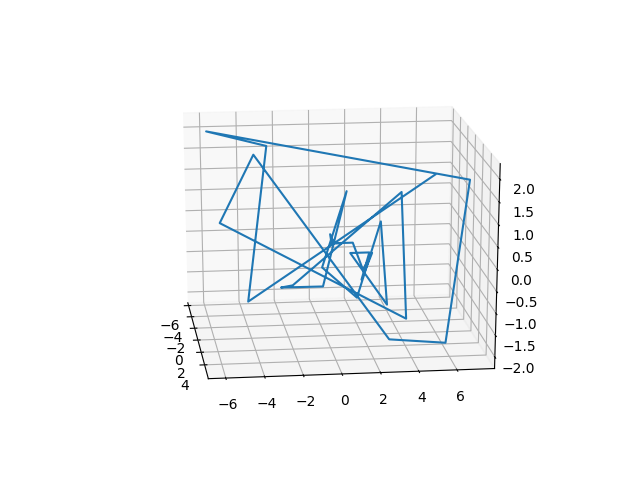

In [5]:
last = None
lastDes = None
locations = []
q = Queue()
queueFrames.q = q
now = time.time()
#start reading image frames in background
Process(target=queueFrames).start()
while True:
    grayImg = q.get(timeout=100)
    if grayImg is None:
        break
    kp, des = orb.detectAndCompute(grayImg, None)
    
    if last == None:
        last = kp
        lastDes = des
        continue
    
    # BFMatcher with default params
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(lastDes, des)
    # Apply ratio test
    
    F = ransacF(matches, kp, last)
    updateLoc(F, matches)
    locations.append(location)
    del last
    del lastDes
    last = kp
    lastDes = des
    
after = time.time()
print("time elapsed: {0}".format(after - now))
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot([np.reshape(location, (4,1))[0,0] for location in locations],
       [np.reshape(location, (4,1))[1,0] for location in locations],
       [np.reshape(location, (4,1))[2,0] for location in locations], label="locations")
plt.show()